In [48]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
import rasterio
from rasterio.transform import from_origin

from chronocluster.data.simdata import generate_random_points, bise
from chronocluster.data.dataio import pts_df_to_gis, kde_to_geotiff
from chronocluster import clustering
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, get_box, chrono_plot, draw_ellipses
from chronocluster.distributions import ddelta
from chronocluster.clustering import Point
from chronocluster.density import kde_time, custom_kde, pymc_gmm_peak_finder, kde_peaks, rank_peaks

In [15]:
# data wrangling
df = pd.read_csv('../Data/temples.csv')
df = df.dropna(subset=['xeast', 'ynorth', 'date'])
df

,id,morph,azimuth,area,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,...,trait_8,name,date,dating_notes,xlong,ylat,date_type,xeast,ynorth,date_emp
0,876,square,90.424247,90.860298,False,False,True,False,True,True,...,False,Unknown,995.0,Date derived from art historical analyses of l...,103.85821,13.42621,empirical,376391.1,1484555.0,995.0
1,874,square,90.000000,121.102386,False,False,False,False,True,True,...,False,Sâk Krâop (Pr.),889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376029.9,1484559.0,889.0
2,878,square,90.000000,144.909427,False,False,True,False,True,True,...,False,Tuol,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,376568.1,1484474.0,889.0
3,933,square,90.000000,182.458280,False,False,True,False,False,False,...,False,Top (Pr.),1115.0,Temple is included in the CCC,NaN,NaN,empirical,377453.2,1486464.0,1115.0
4,973,square,90.658658,185.512325,False,False,NaN,NaN,NaN,NaN,...,NaN,Angkor Thom (Laterite slabs and sculpture debris),1002.0,Temple is included in the CCC during Period 3.,NaN,NaN,empirical,377851.6,1486810.0,1002.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,6996,NaN,NaN,NaN,NaN,NaN,True,False,True,False,...,False,Unknown,1166.0,Date derived through graph-based semi-supervis...,103.77332,13.37078,graphbased,367166.2,1478474.0,NaN
1388,7001,NaN,NaN,NaN,NaN,NaN,False,False,False,True,...,False,Unknown,848.0,Date derived through graph-based semi-supervis...,103.94124,13.36301,graphbased,385365.8,1477530.0,NaN
1389,7002,NaN,NaN,NaN,NaN,NaN,True,False,False,True,...,False,Unknown,934.0,Date derived through graph-based semi-supervis...,103.89110,13.33931,graphbased,379910.8,1474927.0,NaN
1391,7005,NaN,NaN,NaN,NaN,NaN,True,False,True,False,...,False,Unknown,1166.0,Date derived through graph-based semi-supervis...,103.94205,13.35556,graphbased,385420.9,1476712.0,NaN


In [16]:
points = [
    clustering.Point(
        x=row['xeast'],
        y=row['ynorth'],
        start_distribution = ddelta(row['date']),
        end_distribution = ddelta(1500)
    )
    for _, row in df.iterrows()
]

In [17]:
points

[Point(x=376391.1, y=1484555.0, start_distribution=ddelta(d=995.0), end_distribution=ddelta(d=1500)),
 Point(x=376029.9, y=1484559.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=376568.1, y=1484474.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=377453.2, y=1486464.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377851.6, y=1486810.0, start_distribution=ddelta(d=1002.0), end_distribution=ddelta(d=1500)),
 Point(x=377220.5, y=1487538.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=377181.0, y=1487114.0, start_distribution=ddelta(d=926.0), end_distribution=ddelta(d=1500)),
 Point(x=377328.8, y=1486122.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=375082.2, y=1487158.0, start_distribution=ddelta(d=926.0), end_distribution=ddelta(d=1500)),
 Point(x=376487.6, y=1484022.0, start_distribution=ddelta(d=958.0), end_distri

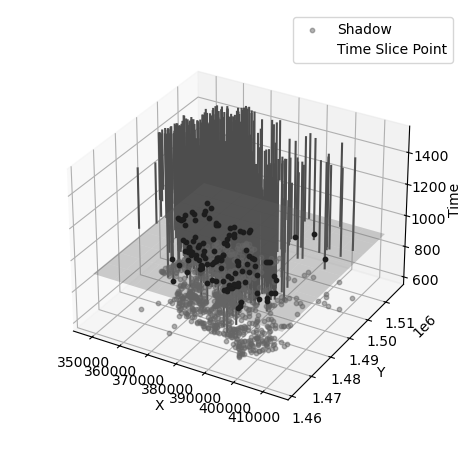

In [18]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=900)
ax.set_box_aspect(None, zoom=0.85)

In [19]:
# Define the time slices
start_time = 800
end_time = 1200
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)

# Precompute inclusion probabilities based on age models and time slices
inclusion_probs = clustering.in_probs(points, time_slices)

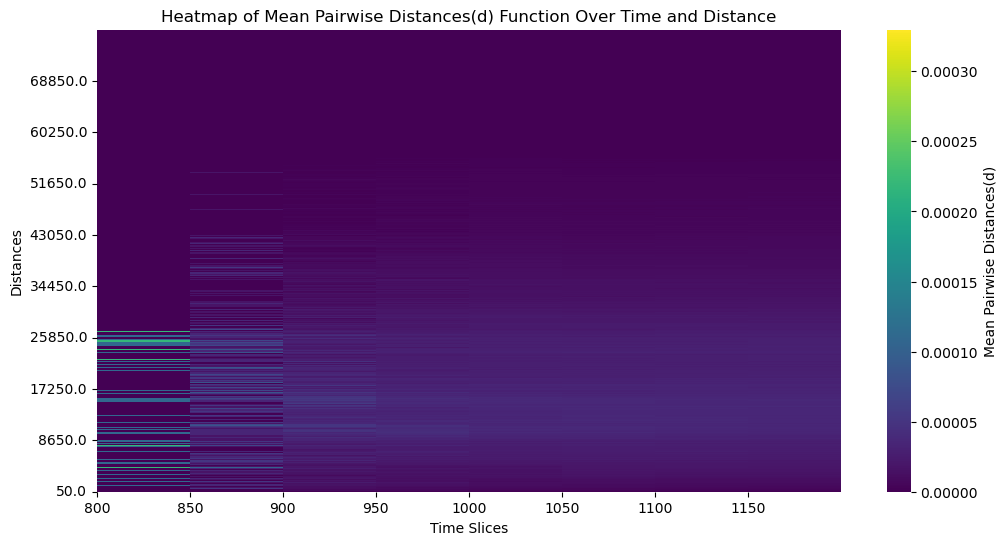

In [20]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points, 
                                    time_slices, 
                                    inclusion_probs, 
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)
pair_bw = 100

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=pair_bw, 
                                                         density=False, 
                                                         max_distance=max_distance)

# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

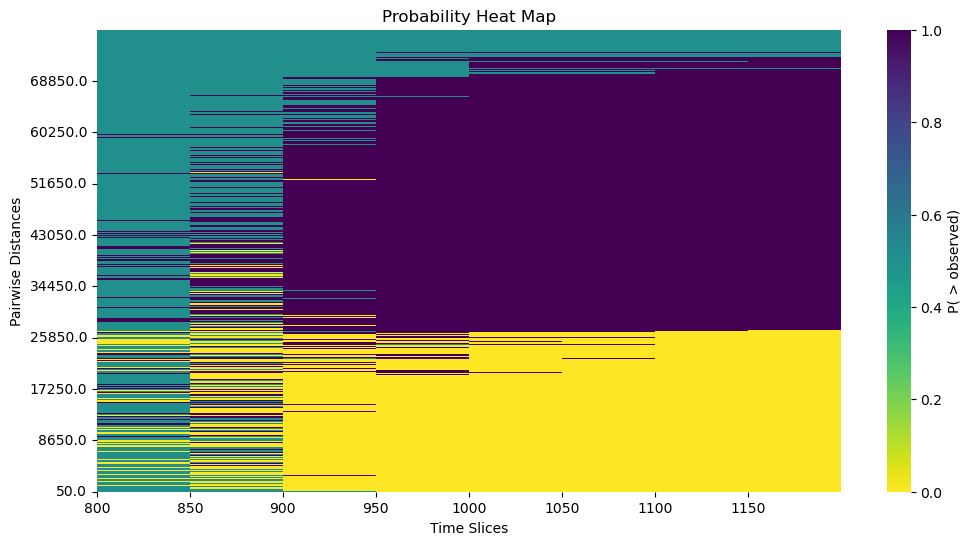

In [21]:
# Generate CSR sample
csr_points = clustering.csr_sample(points, x_min, x_max, y_min, y_max)

# Get CSR inclusion probabilities (remember these points have the same
# temporal traits as the first simulated data)
csr_inclusion_probs = clustering.in_probs(csr_points, 
                                          time_slices)

# Get MC iterations for incorporating chronological uncertainty
num_iterations = 100
csr_simulations = clustering.mc_samples(csr_points, 
                                        time_slices, 
                                        csr_inclusion_probs, 
                                        num_iterations = num_iterations)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 density = False, 
                                                                 max_distance = max_distance)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)

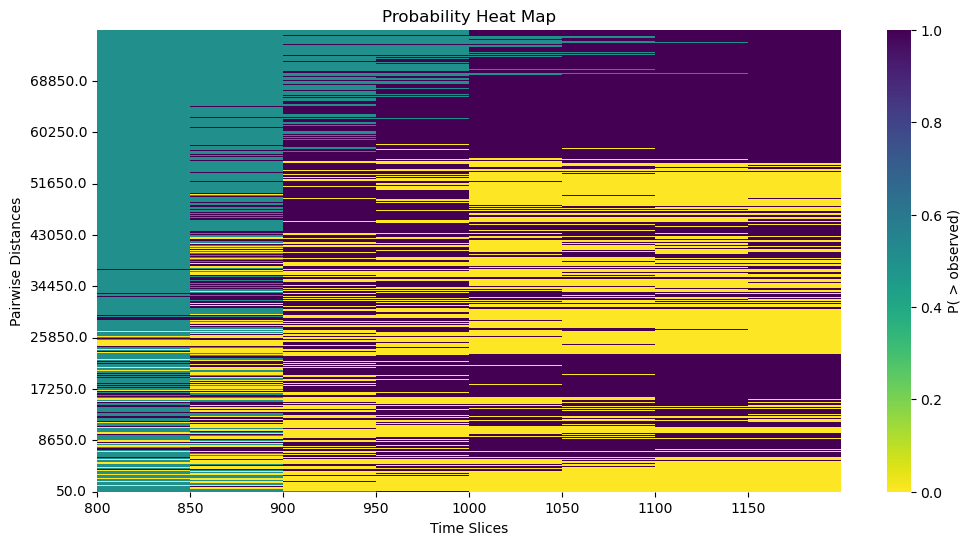

In [22]:
# Generate BISE sample
mean_location, cov_matrix, simulated_coords, bise_points = bise(points, nsim=len(points))

# Get LISE inclusion probabilities (similar temporal traits as the original data)
bise_inclusion_probs = clustering.in_probs(bise_points, 
                                           time_slices)

# Get MC iterations for incorporating chronological uncertainty
num_iterations = 100
bise_simulations = clustering.mc_samples(bise_points, 
                                         time_slices, 
                                         bise_inclusion_probs, 
                                         num_iterations=num_iterations)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density, bise_support = clustering.temporal_pairwise(bise_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 density = False, 
                                                                 max_distance = max_distance)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array = clustering.p_diff(pairwise_density, bise_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              bise_support)

In [23]:
# Define grid resolution and create the 2D grid for KDE evaluation
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

grid_resolution = 100  # Adjust the number of points as needed for resolution
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
grid = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T  # Flatten the grid for KDE input

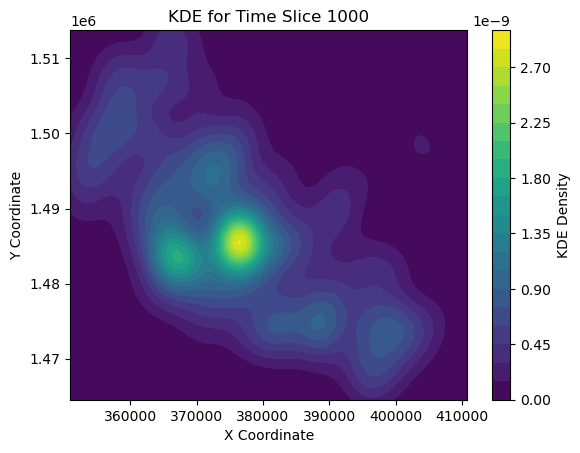

In [ ]:
# Set parameters for KDE, including arbitrary time_slice from simulated data
time_slice = 1000
bandwidth =  4250 * 0.5

# Calculate KDE for the chosen time slice
kde_values = kde_time(points, 
                      time_slice, 
                      bandwidth, 
                      grid, 
                      output_shape=x_mesh.shape, 
                      kde_method=custom_kde)

# Plotting
plt.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
plt.colorbar(label="KDE Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"KDE for Time Slice {time_slice}")
plt.show()

In [41]:
kde_to_geotiff(x_mesh, 
               y_mesh, 
               kde_values, 
               epsg_code=32648, 
               output_path="../Output/angkor_temples_kde_output.tif")

GeoTIFF saved as ../Output/angkor_temples_kde_output.tif


In [33]:
# Calculate the spatial extent based on bounding box to constrain the prior for
# the component means (parameter space outside this area is going to be fruitless)
bounding_box_variance = ( max_distance/ 2)**2

# Set maximum number of components to allow in the model
max_components = 8
w_threshold = 1 / max_components # used for idenitifying peak importance

# Priors for spatial scale (variance) based on pairwise distance density analysis
target_scale = bandwidth  # This is our target spatial scale for each component
target_scale_sd = 100  # Some variation around this value

# Run kde_peaks with GMM as the peak-finding method
# Assuming coordinates is your dataset of temple locations, passed as Point objects
peaks, weights, trace = kde_peaks(points=points, 
                                    num_peaks=max_components, 
                                    peak_finder=pymc_gmm_peak_finder,
                                    time_slice = time_slice,
                                    target_scale = target_scale,
                                    target_scale_sd = target_scale_sd,
                                    w_threshold = w_threshold,
                                    sampler = 'NUTS',
                                    draws = 2000,
                                    tune = 4000,
                                    chains = 1)

Sequential sampling (1 chains in 1 job)
NUTS: [w, means, chol_0, chol_1, chol_2, chol_3, chol_4, chol_5, chol_6, chol_7]


Output()

c:\Users\carleton\AppData\Local\miniconda3\envs\pybayes\Lib\site-packages\pytensor\compile\function\types.py:970: 
RuntimeWarning: invalid value encountered in accumulate
  self.vm()

Sampling 1 chain for 4_000 tune and 2_000 draw iterations (4_000 + 2_000 draws total) took 519 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [37]:
importance_hdi = 0.80
summary_df = rank_peaks(trace, significance=importance_hdi, source_param='importance')

# isolate important peaks
# Filter rows where the lower bound of the HDI is greater than importance_threshold
importance_threshold = 0
condition = summary_df[f'{int(importance_hdi * 100)}% HDI (Importance)'].apply(lambda hdi: hdi[0] > importance_threshold)
important_peaks = summary_df[condition] # isloated for plotting below
summary_df

,Rank,Importance,Coordinates,Covariances,80% HDI (Importance)
0,1,0.087578,"(377385.6529331044, 1485169.5367566783)","[[7374396.287126393, 1493067.3147973577], [149...","(0.06856614615039555, 0.10757191782761569)"
1,2,0.074619,"(366832.70363001886, 1483598.9338650438)","[[7087140.612641852, -3808487.764084838], [-38...","(0.05426365688303497, 0.09172334749128988)"
2,3,0.026749,"(358948.27429878403, 1501898.488063713)","[[9226266.91493607, 4844700.774548829], [48447...","(0.011421203966610671, 0.0403583278775895)"
3,4,0.011343,"(372470.24946893216, 1495778.2027499175)","[[8083542.702471987, 1804433.9630586437], [180...","(-0.005437460078052986, 0.0259932799931559)"
4,5,-0.003264,"(384448.7346455228, 1474965.7563110902)","[[9545782.77032419, 1949234.0339978398], [1949...","(-0.017897130773347064, 0.009173929529786101)"
5,6,-0.023689,"(398503.4978272326, 1472560.7021841814)","[[7264170.83078183, 1929218.7037550132], [1929...","(-0.037514676936192676, -0.009777238865013888)"
6,7,-0.070566,"(391847.56334311434, 1488533.7803683698)","[[7022408.948567453, -741412.5101304246], [-74...","(-0.08262953995583455, -0.0606476410708071)"
7,8,-0.102769,"(399364.7886691121, 1502150.980095431)","[[8721364.477511398, -3161323.795189182], [-31...","(-0.10873563374942843, -0.09690764990684059)"


In [43]:
pts_df_to_gis(summary_df,
              epsg_code=32648,
              output_path="../Output/angkor_temple_cluster_centres.gpkg", 
              file_format="GPKG")

Points saved to ../Output/angkor_temple_cluster_centres.gpkg as GPKG


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


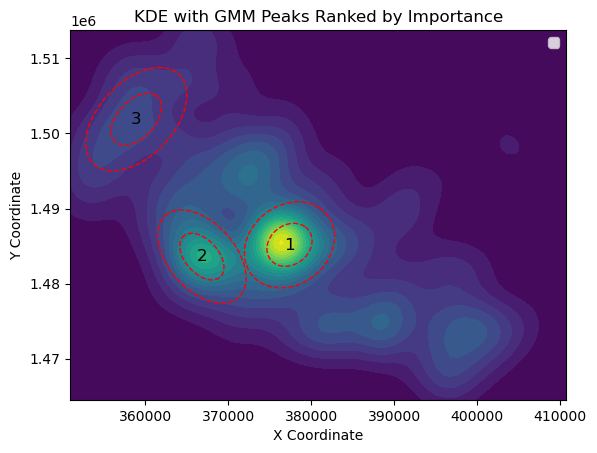

In [ ]:
# Plotting
fig, ax = plt.subplots()

# Plot KDE density surface
ax.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')

# Extract the X and Y coordinates from the Coordinates column for plotting
x_coords = important_peaks['Coordinates'].apply(lambda coord: coord[0])
y_coords = important_peaks['Coordinates'].apply(lambda coord: coord[1])

# Plot the original data points
#ax.scatter(summary_df['x'], summary_df['y'], color='white', marker='o', s=5, label='Original Data')

# Draw ellipses for the GMM components with 1 SD and 2 SD ranges
draw_ellipses(ax, 
              important_peaks, 
              std_devs=[1, 2], 
              edgecolor='red', 
              facecolor='none', 
              linestyle='--', 
              linewidth=1)

# Annotate each component with its rank
for x, y, rank in zip(x_coords, y_coords, important_peaks['Rank']):
    ax.text(x, y, rank, color='black', ha='center', va='center', fontsize=12)

# Add legend, labels, and title
ax.legend()
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("KDE with GMM Peaks Ranked by Importance")

plt.show()